### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import circuitsvis as cv
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens

from pii import utils
from pii.prompt_data import LensData, PromptData

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompts

In [5]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>
Complete the statment. {question} [/INST] \
"""


def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You will never say the forbidden word {forbidden_word}.
<</SYS>>

{question} [/INST] \
"""

# question = "Miles Davis plays the"
# forbidden_words = ["apple", "Trumpet"]
question = "Lionel Messi plays the sport of"
forbidden_words = ["apple", "football"]
# question = "Carlos Alcaraz plays the sport of"
# forbidden_words = ["apple", "Tennis"]
# question = "The capital of Germany is"
# forbidden_words = ["apple", "Berlin"]

In [ ]:
for i, corr in enumerate([True, False]):
    prompt = get_corr_prompt(question, correct=corr)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

In [ ]:
for i, forbidden_word in enumerate(forbidden_words):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

### Cache activations and compute lens data

In [ ]:
prompt_dict = dict(
    corr_base=PromptData.get_data(get_corr_prompt(question), tl_model),
    corr_competing=PromptData.get_data(get_corr_prompt(question, correct=False), tl_model),
    dontsay_base=PromptData.get_data(get_dontsay_prompt(question, forbidden_words[0]), tl_model),
    dontsay_competing=PromptData.get_data(get_dontsay_prompt(question, forbidden_words[1]), tl_model),
)

for prompt_type in ["corr", "dontsay"]:
    base_data = prompt_dict[f"{prompt_type}_base"]
    competing_data = prompt_dict[f"{prompt_type}_competing"]

    print(f"Logits for {prompt_type}_base")
    print(base_data.ml_str, base_data.ml_token, base_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, base_data.final_logits[competing_data.ml_token].item())
    print(f"Logits for {prompt_type}_competing")
    print(base_data.ml_str, base_data.ml_token, competing_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, competing_data.final_logits[competing_data.ml_token].item())

lens_dict = {
    k: LensData.get_data(
        prompt_data=v,
        tl_model=tl_model,
        logit_lens=logit_lens,
        tuned_lens=tuned_lens,
    )
    for k, v in prompt_dict.items()
}

In [ ]:
lens_dict = {
    k: LensData.get_data(
        prompt_data=v,
        tl_model=tl_model,
        logit_lens=logit_lens,
        tuned_lens=tuned_lens,
    )
    for k, v in prompt_dict.items()
}

### Plot by head

In [ ]:
lens_type = "logit"
for prompt_type in ["dontsay"]:
    ld_base = lens_dict[f"{prompt_type}_base"]
    ld_comp = lens_dict[f"{prompt_type}_competing"]

    for ld, title in [
        (ld_base, f"{prompt_type} (base)"),
        (ld_comp, f"{prompt_type} (competing)"),
    ]:
        logits, labels = ld.get_logits("attn_head", lens_type=lens_type)
        utils.plot_head_data(
            lines=[
                (
                    f"{lens_type}: |{ld_base.pd.ml_str}|",
                    logits[:, ld_base.pd.ml_token],
                    labels,
                ),
                (
                    f"{lens_type}: |{ld_comp.pd.ml_str}|",
                    logits[:, ld_comp.pd.ml_token],
                    labels,
                ),
            ],
            annotation_text=ld_base.pd.prompt.split("\n")[-1],
            title=title,
            yaxis_title="Logit",
        ).show()

    # for ld, title in [
    #     (ld_base, f"{prompt_type} (base)"),
    #     (ld_comp, f"{prompt_type} (competing)"),
    # ]:
    #     logits, labels = ld.get_logits("mlp_out", lens_type=lens_type)
    #     utils.plot_head_data(
    #         lines=[
    #             (
    #                 f"{lens_type}: |{ld_base.pd.ml_str}|",
    #                 logits[:, ld_base.pd.ml_token],
    #                 labels,
    #             ),
    #             (
    #                 f"{lens_type}: |{ld_comp.pd.ml_str}|",
    #                 logits[:, ld_comp.pd.ml_token],
    #                 labels,
    #             ),
    #         ],
    #         annotation_text=ld_base.pd.prompt.split("\n")[-1],
    #         title=title,
    #         yaxis_title="Logit",
    #     ).show()

### Attention plots

In [ ]:
ld = lens_dict[f"dontsay_competing"]
cache = ld.pd.cache

layer = 26
head = 9
pattern = cache["pattern", layer][head]

print(f"Layer {layer} Head {head} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(pattern[-1]))
    )
)

In [ ]:
head_logits = ld.get_logits(
    "attn_head",
    lens_type="logit",
    flatten=False,
    zero_mean=False,
)[0][layer, head]

print(f"Least likely tokens for L{layer}H{head}")
top_tokens = torch.topk(-head_logits, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({head_logits[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(
    head_logits
    .cpu()
    .numpy(),
    bins=100,
)
plt.show()

### Analyze OV circuit

In [17]:
ftok = tl_model.to_single_token("football")
fpos = 33
assert ld.pd.tokens[fpos].item() == ftok

E_f = tl_model.W_E[ftok]
U_f = tl_model.W_U[:, ftok]
vs = cache["v", layer][:, head]
attn_pattern = cache["pattern", layer][head, -1]
result = cache["result", layer][-1, head]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[layer].ln1
W_V = tl_model.W_V[layer, head]
b_V = tl_model.b_V[layer, head]
W_O = tl_model.W_O[layer, head]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_logit(x):
    return ln_final(x) @ U_f


print(f"L{layer}H{head} stats:")
print_stat("f_logit(result)", f_logit(result))
print_stat(
    "f_logit(pattern @ vs @ W_O)",
    f_logit(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_logit(pattern[fpos] * vs[fpos] @ W_O)",
    f_logit(attn_pattern[fpos] * vs[fpos] @ W_O),
)
print()
print_stat(
    "f_logit(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_logit(attn_pattern[fpos] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_logit(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_logit(attn_pattern[fpos] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "pattern[fpos] * E[fpos] @ W_V @ W_O @ U[ftok]",
    attn_pattern[fpos] * E_f @ W_V @ W_O @ U_f,
)

AssertionError: 

tensor(-12.5197, device='cuda:0')
Tokens L26H9 most downweights from raw embedding
service (-45.756) development (-45.380) follow (-43.818) read (-42.987) features (-42.426) 
family (-42.389) release (-41.461) services (-41.453) develop (-40.856) individual (-40.556) 
developed (-39.357) organization (-38.371) study (-38.284) feature (-38.129) reading (-37.992) 
Development (-36.977) leader (-36.628) force (-36.596) writing (-36.578) change (-36.422) 
available (-36.365) professional (-36.166) studies (-35.603) developing (-35.208) examples (-34.962) 
image (-34.801) Service (-34.740) following (-34.442) company (-34.427) students (-33.909) 
leaders (-33.895) address (-33.813) write (-33.704) provided (-33.644) cause (-33.610) 
issues (-33.326) government (-33.114) service (-33.101) changes (-33.037) forces (-33.034) 
Develop (-32.914) follows (-32.799) see (-32.625) released (-32.555) security (-32.487) 
use (-32.449) country (-32.416) companies (-32.411) issue (-32.289) approach (-32

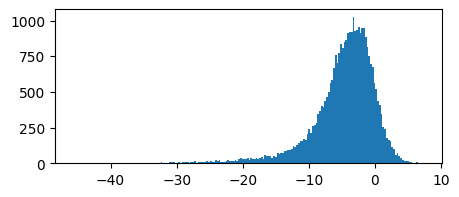

In [18]:
m1 = W_V @ W_O
rmsdiv = lambda x: x / x.pow(2).mean(dim=-1, keepdim=True).sqrt()
m2 = torch.diag(tl_model.ln_final.w) @ tl_model.W_U

responses = (rmsdiv(tl_model.W_E @ m1) @ m2).diag()
print(responses[ftok])
print(f"Tokens L{layer}H{head} most downweights from raw embedding")
top_tokens = torch.topk(-responses, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({responses[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(responses.cpu().numpy(), bins=200);

In [19]:
print(responses.shape)
first10 = responses[0:10]
print(first10)
top_tokens = torch.topk(-responses, 50)
print(top_tokens)
print(top_tokens)

torch.Size([32000])
tensor([ 0.9452,  5.7157, -0.5448, -0.8144, -4.6455, -2.1594, -2.9435, -1.5630,
        -2.9376,  0.1650], device='cuda:0')
torch.return_types.topk(
values=tensor([45.7562, 45.3798, 43.8183, 42.9868, 42.4257, 42.3885, 41.4615, 41.4532,
        40.8558, 40.5559, 39.3573, 38.3713, 38.2843, 38.1289, 37.9917, 36.9766,
        36.6281, 36.5958, 36.5778, 36.4223, 36.3649, 36.1657, 35.6030, 35.2082,
        34.9623, 34.8014, 34.7398, 34.4422, 34.4268, 33.9087, 33.8947, 33.8134,
        33.7043, 33.6440, 33.6099, 33.3255, 33.1144, 33.1010, 33.0373, 33.0338,
        32.9138, 32.7986, 32.6250, 32.5552, 32.4866, 32.4487, 32.4155, 32.4111,
        32.2893, 32.2552], device='cuda:0'),
indices=tensor([ 2669,  5849,  1101,  1303,  5680,  3942,  6507,  5786,  2693,  5375,
         8906, 13013,  6559,  4682,  5183, 14650, 11822,  4889,  5007,  1735,
         3625, 10257, 11898, 14338,  6455,  1967,  6692,  1494,  5001,  8041,
        20251,  3211,  2436,  4944,  4556,  5626,  5874, 

### Studying forbidden enrichment on OV circuit

In [6]:
word_list = ["hello", "football"]
word_list = ['<unk>']
word_list = [
    "apple", "blue", "cat", "door",
    "flower", "guitar", "house", "island",
    "lamp", "mountain", "orange",
    "piano", "queen", "river", "sun", "table",
    "window",
    "beach", "cloud", "dog", "forest",
    "hat",
    "moon", "night", "ocean",
    "rose", "tree",
    "water", "yellow", "zoo", "book",
    "and", "the", "to", "of", "in",
    "is", "you", "that", "it", "he",
    "was", "for", "on", "are", "as",
    "with", "his", "they", "I", "at",
    "be", "this", "have", "from", "or",
    "one", "had", "by", "word", "but",
    "not", "what", "all", "were", "we",
    "when", "your", "can", "said", "there",
    "use", "an", "each", "which", "she",
    "do", "how", "their", "if", "will",
    "up", "out", "many", "then", "them",
    "these", "so", "some", "her", "would",
    "make", "like", "him", "into", "time",
    "has", "look", "two", "more", "write",
    "go", "see", "number", "no", "way",
    "could", "people", "my", "than", "first",
    "water", "been", "call", "who", "oil",
    "its", "now", "find", "long", "down",
    "day", "did", "get", "come", "made",
    "may", "part", "over", "new", "sound",
    "take", "only", "little", "work", "know",
    "place", "year", "live", "me", "back",
    "give", "most", "very", "after", "thing",
    "our", "just", "name", "good", "sentence",
    "man", "think", "say", "great", "where",
    "help", "through", "much", "before", "line",
    "right", "too", "means", "old", "any",
    "same", "tell", "boy", "follow", "came",
    "want", "show", "also", "around", "form",
    "three", "small", "set", "put", "end"]



prompt = get_dontsay_prompt(question, "football")
prompt_tokens = tokenizer.encode(prompt)
print(tokenizer.decode(prompt_tokens))
prompt_tokens[33] = 20000
print(tokenizer.decode(prompt_tokens))

token_list = [i for i in range(32000)]

def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_logit(x):
    return ln_final(x) @ U_f

<s> [INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You will never say the forbidden word football.
<</SYS>>

Lionel Messi plays the sport of [/INST] 
<s> [INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You will never say the forbidden word admit.
<</SYS>>

Lionel Messi plays the sport of [/INST] 


In [ ]:
enriched_list = []
nonenriched_list = []
for i in range(len(token_list)):
    prompt_tokens[33] = token_list[i]
    prompt_dict = dict(
        dontsay_competing=PromptData.get_data(prompt_tokens, tl_model),
    )

    lens_dict = {
        k: LensData.get_data(
            prompt_data=v,
            tl_model=tl_model,
            logit_lens=logit_lens,
            tuned_lens=tuned_lens,
        )
        for k, v in prompt_dict.items()
    }

    ld = lens_dict[f"dontsay_competing"]
    cache = ld.pd.cache

    layer = 26
    head = 9
    pattern = cache["pattern", layer][head]

    ftok = token_list[i]
    # print(ftok)
    fpos = 33
    # print(ld.pd.tokens[fpos].item())
    # print(tokenizer.decode(ld.pd.tokens[fpos].item()))
    # print(tokenizer.decode(ld.pd.tokens))
    assert ld.pd.tokens[fpos].item() == ftok

    E_f = tl_model.W_E[ftok]
    U_f = tl_model.W_U[:, ftok]
    vs = cache["v", layer][:, head]
    attn_pattern = cache["pattern", layer][head, -1]
    result = cache["result", layer][-1, head]

    ln_final = tl_model.ln_final
    ln1 = tl_model.blocks[layer].ln1
    W_V = tl_model.W_V[layer, head]
    b_V = tl_model.b_V[layer, head]
    W_O = tl_model.W_O[layer, head]

    enriched_logit = f_logit(attn_pattern[fpos] * vs[fpos] @ W_O)
    enriched_list.append(enriched_logit.item())
    logit = f_logit(attn_pattern[fpos] * E_f @ W_V @ W_O)
    nonenriched_list.append(logit.item())

In [26]:
print(enriched_list)
print(nonenriched_list)

[0.2748655080795288, 0.9097357988357544, 0.6902676820755005, 0.1155804693698883, -2.385244607925415, -1.1985790729522705, -3.547736167907715, -0.3325241804122925, -0.09453800320625305, -0.22959157824516296, -0.5494751930236816, 0.24321569502353668, -0.32639697194099426, 0.07251103222370148, -0.48941540718078613, -1.0107580423355103, 0.28299105167388916, -0.508062481880188, -0.49833160638809204, -0.26654669642448425, -0.32478541135787964, 0.24467679858207703, -0.4307815134525299, 0.26746901869773865, -0.9044155478477478, -0.3645673096179962, -0.11465862393379211, 0.09870249032974243, -0.13696561753749847, -1.412912368774414, -0.5190143585205078, -0.7665528655052185, -0.4236154854297638, 0.1518746018409729, -0.09520003199577332, 0.2503679394721985, 0.27856141328811646, 0.27245211601257324, 0.29976746439933777, 0.2816373109817505, 0.2726415991783142, 0.2783798575401306, 0.2822727560997009, 0.27948513627052307, 0.2714952528476715, 0.2791818678379059, 0.2742064595222473, 0.2752942144870758,

In [28]:
mean_enriched = sum(enriched_list)/len(enriched_list)
mean_nonenriched = sum(nonenriched_list)/len(nonenriched_list)
print(mean_enriched)
print(mean_nonenriched)

-5.324765866209724
-0.6629430627758138


In [11]:
import pickle
with open('enriched_list.pkl', 'wb') as f:
    pickle.dump(enriched_list, f)

In [13]:
with open('nonenriched_list.pkl', 'wb') as f:
    pickle.dump(nonenriched_list, f)

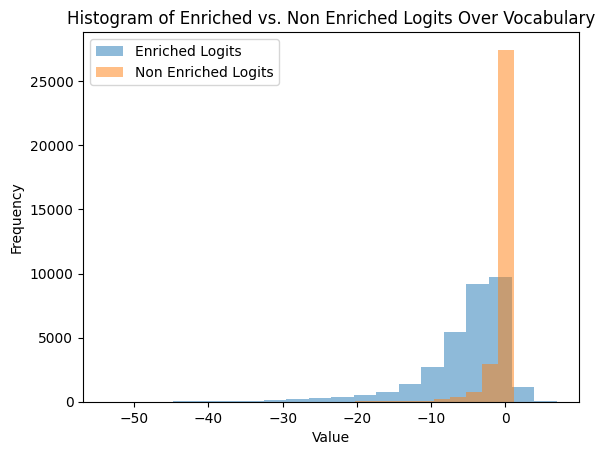

In [23]:
# plt.hist([enriched_list, nonenriched_list], bins=30, alpha=0.5, label=['Enriched Logits', 'Non Enriched Logits'])

plt.hist(enriched_list, bins=20, alpha=0.5, label='Enriched Logits')
plt.hist(nonenriched_list, bins=20, alpha=0.5, label='Non Enriched Logits')
plt.legend(loc='upper left')
plt.title('Histogram of Enriched vs. Non Enriched Logits Over Vocabulary')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

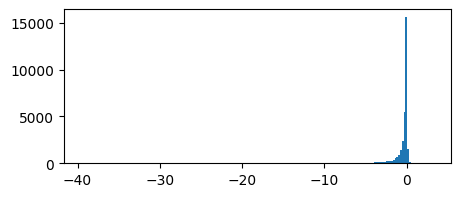

In [21]:
plt.figure(figsize=(5, 2))
plt.hist(nonenriched_list, bins=200);